In [1]:
# Install minimal dependencies (`torch`, `transformers`, `timm`, `tokenizers`, ...)
# > pip install -r https://raw.githubusercontent.com/openvla/openvla/main/requirements-min.txt
from transformers import AutoModelForVision2Seq, AutoProcessor
from PIL import Image
import torch

path = '/home/hw/youzeshun/model/openvla-7b'
# Load Processor & VLA
processor = AutoProcessor.from_pretrained(path, trust_remote_code=True)
vla = AutoModelForVision2Seq.from_pretrained(
    path, 
    attn_implementation="flash_attention_2",  # [Optional] Requires `flash_attn`
    torch_dtype=torch.bfloat16, 
    low_cpu_mem_usage=True, 
    trust_remote_code=True
).to("cuda:0")

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
You are attempting to use Flash Attention 2.0 without specifying a torch dtype. This might lead to unexpected behaviour


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

[2025-01-17 20:27:11.858] [svulkan2] [error] GLFW error: X11: The DISPLAY environment variable is missing
[2025-01-17 20:27:11.858] [svulkan2] [warning] Continue without GLFW.
/data/miniconda3/envs/yzs_simpler_env_openvla/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_language_instruction to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_language_instruction` for environment variables or `env.get_wrapper_attr('get_language_instruction')` that will search the reminding wrappers.
  logger.warn(
/data/miniconda3/envs/yzs_simpler_env_openvla/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.robot_uid to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.robot_uid` for environment variables or `env.get_wrapper_attr('robot_uid')` that will search the reminding wrappers.
  logger.warn(

Reset info {'scene_name': 'google_pick_coke_can_1_v4', 'scene_offset': None, 'scene_pose': None, 'scene_table_height': 0.87, 'urdf_version': 'recolor_tabletop_visual_matching_1', 'rgb_overlay_path': '/home/hw/youzeshun/SimplerEnv/ManiSkill2_real2sim/data/real_inpainting/google_coke_can_real_eval_1.png', 'rgb_overlay_cameras': ['overhead_camera'], 'rgb_overlay_mode': 'background', 'disable_bad_material': False, 'model_id': 'opened_coke_can', 'model_scale': 1.0, 'distractor_model_ids': None, 'distractor_model_scales': None, 'obj_init_pose_wrt_robot_base': Pose([0.587925, -0.0238302, 0.840576], [0.707052, -0.0081018, -0.01162, -0.70702]), 'orientation': 'laid_vertically'}
Instruction pick coke can


""

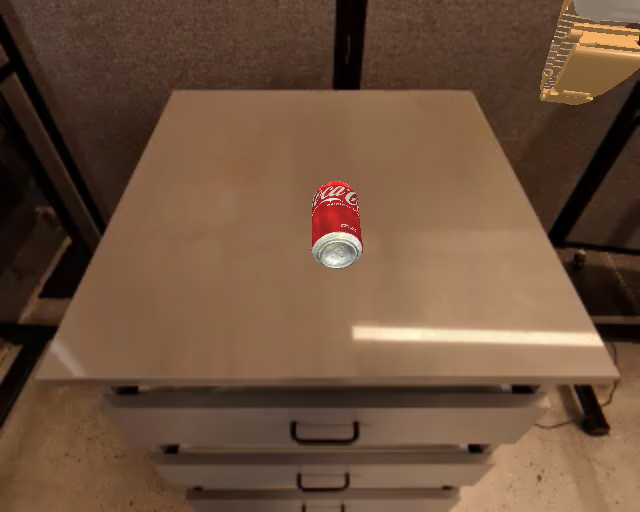

""

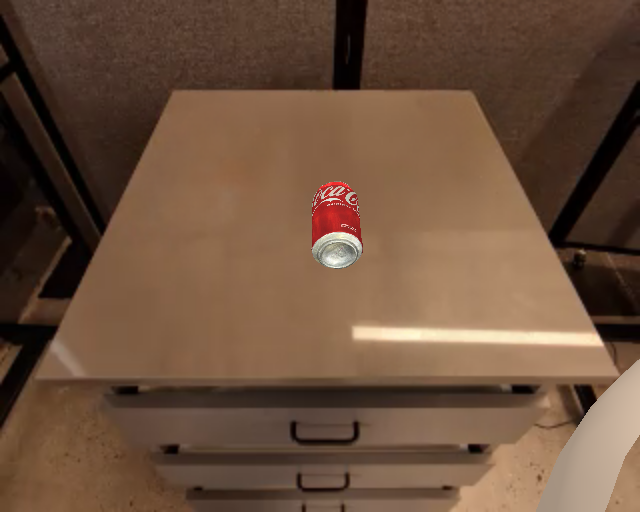

Episode stats OrderedDict([('n_lift_significant', 0), ('consec_grasp', False), ('grasped', False)])


In [ ]:
import simpler_env
from simpler_env.utils.env.observation_utils import get_image_from_maniskill2_obs_dict
import mediapy
import sapien.core as sapien
import numpy as np
import cv2
import base64
from PIL import Image

task_name = "google_robot_pick_coke_can"  # @param ["google_robot_pick_coke_can", "google_robot_move_near", "google_robot_open_drawer", "google_robot_close_drawer", "widowx_spoon_on_towel", "widowx_carrot_on_plate", "widowx_stack_cube", "widowx_put_eggplant_in_basket"]

# Check if an environment object named `env` already exists. If so, close and delete it.
if 'env' in locals(): 
  print("Closing existing env")
  env.close()
  del env

# Create a new task environment
env = simpler_env.make(task_name)

# Reset environment and return the initial observation and reset info
obs, reset_info = env.reset()

# Get language instruction associated with the task (usually task description)
instruction = env.get_language_instruction()
print("Reset info", reset_info)
print("Instruction", instruction)

frames = []
done, truncated = False, False
while not (done or truncated):
   # Extract image from observation
   image = get_image_from_maniskill2_obs_dict(env, obs)

   # Convert to format compatible with OpenVLA (format may vary depending on model)
   o_image = Image.fromarray(image)
    
   # Compose prompt
   prompt = "In: What action should the robot take to {pick coke can}?\nOut:"

   # Predict 7-DoF action (unnormalized for BridgeData V2)
   inputs = processor(prompt, o_image).to("cuda:0", dtype=torch.bfloat16)
   action = vla.predict_action(**inputs, unnorm_key="bridge_orig", do_sample=False)
    
   # Execute action
   # action[:3]   → translation (xyz)
   # action[3:6] → rotation (axis-angle representation)
   # action[6:7] → gripper control (open/close)
   # print(action)

   # Apply action and get new observation, reward, done/truncated flags, and info
   obs, reward, done, truncated, info = env.step(action)
   frames.append(image)

   # Display image every 30 steps
   if len(frames) % 30 == 0: 
       mediapy.show_image(image)
    
episode_stats = info.get('episode_stats', {})
print("Episode stats", episode_stats)

# Show video of the episode
mediapy.show_video(frames, fps=10)
# mediapy.show_image(image)
